# Atlas

## In this Notebook we will show step-by-step how the halo pipeline retrieves a light curve of Atlas. 

## We will focus on just one systematic segment and compare first and second order Total Variation, and with and without masking out a faint star.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy.optimize as optimize
import fitsio
from time import time as clock

% matplotlib inline

import matplotlib as mpl

print mpl.style.available
mpl.style.use('seaborn-colorblind')

from halophot.halo_tools import *
import halophot.halo_tools
reload(halophot.halo_tools)

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [225]:
atlas = './ktwo200007768-c04_lpd-targ.fits' # load your favourite target

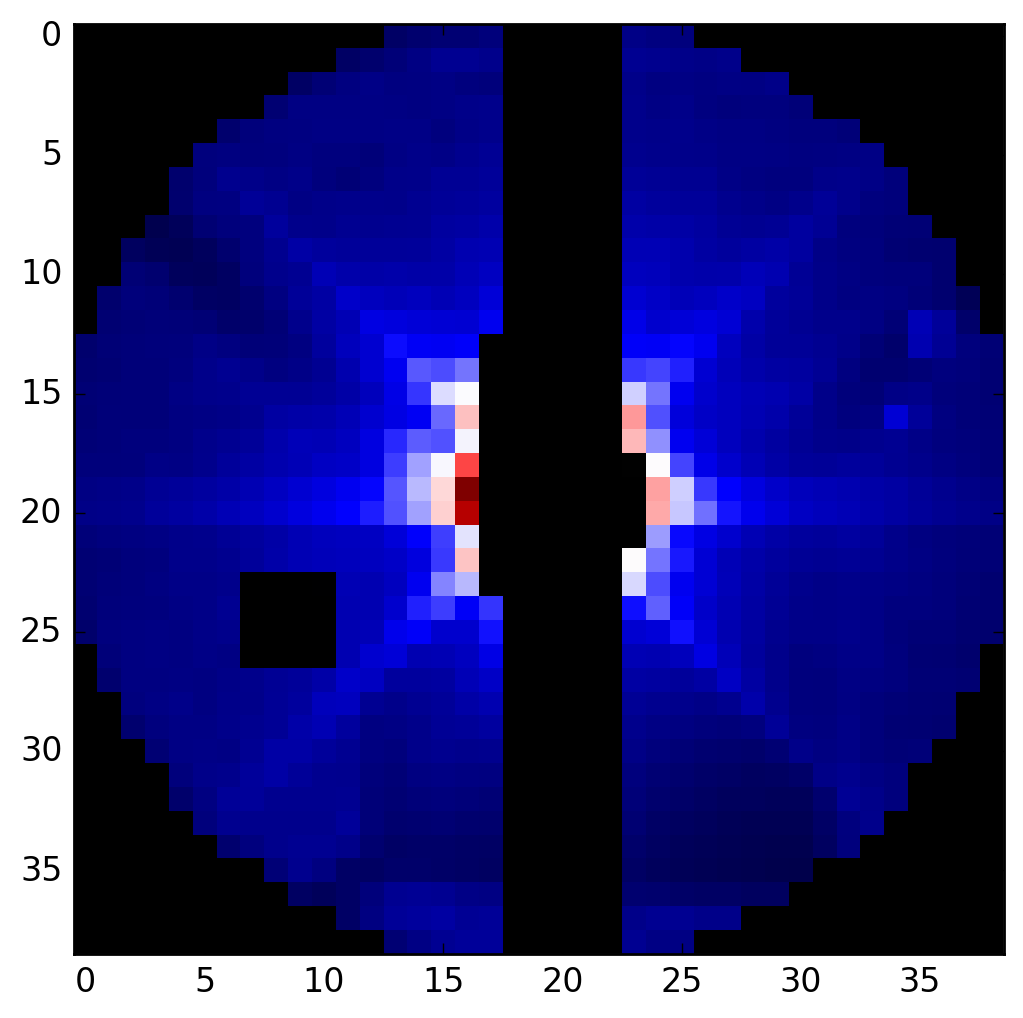

In [242]:
tpf, ts = read_tpf(atlas)
sub = 8 # subsampling parameter - take every sub-th pixel in a ravelled sense. It works fine down to ~16th and runs fast!

tpf, ts = get_slice(tpf,ts,570,2100) # we will just do a section of Atlas for the sake of speed

tpfm = tpf.copy() # get masked tpf 
tpfm[:,23:27,7:11] = np.nan # block out star
tsm = ts.copy()

pixels, ts, mapping = censor_tpf(tpf,ts,thresh=0.8) # throw away nans and bad cadences
pixelsm, tsm, mappingm = censor_tpf(tpfm,tsm,thresh=0.8)

cmap = mpl.cm.seismic
cmap.set_bad('k')

plt.imshow(tpfm[5,:,:]**0.5,interpolation='None',cmap=cmap)

In [219]:
pixelmap = np.zeros((tpf.shape[1],tpf.shape[2]))

pixels_sub, ts_sub = pixels[::sub,:], ts[::sub]  # subsample

pixelmapm = np.zeros((tpfm.shape[1],tpfm.shape[2]))

pixels_subm, ts_subm = pixelsm[::sub,:], tsm[::sub]

In [220]:
weights_1, opt_lc = tv_tpf(pixels_sub,order=1,maxiter=600)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.291189556764
            Iterations: 50
            Function evaluations: 6686
            Gradient evaluations: 50


In [221]:
weights_2, opt_lc2 = tv_tpf(pixels_sub,order=2,w_init=weights_1)

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.806925697082
            Iterations: 102
            Function evaluations: 13685
            Gradient evaluations: 102


In [210]:
weights_2m, opt_lc2m = tv_tpf(pixels_subm,order=2,maxiter=600)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.84064262543
            Iterations: 83
            Function evaluations: 10939
            Gradient evaluations: 83


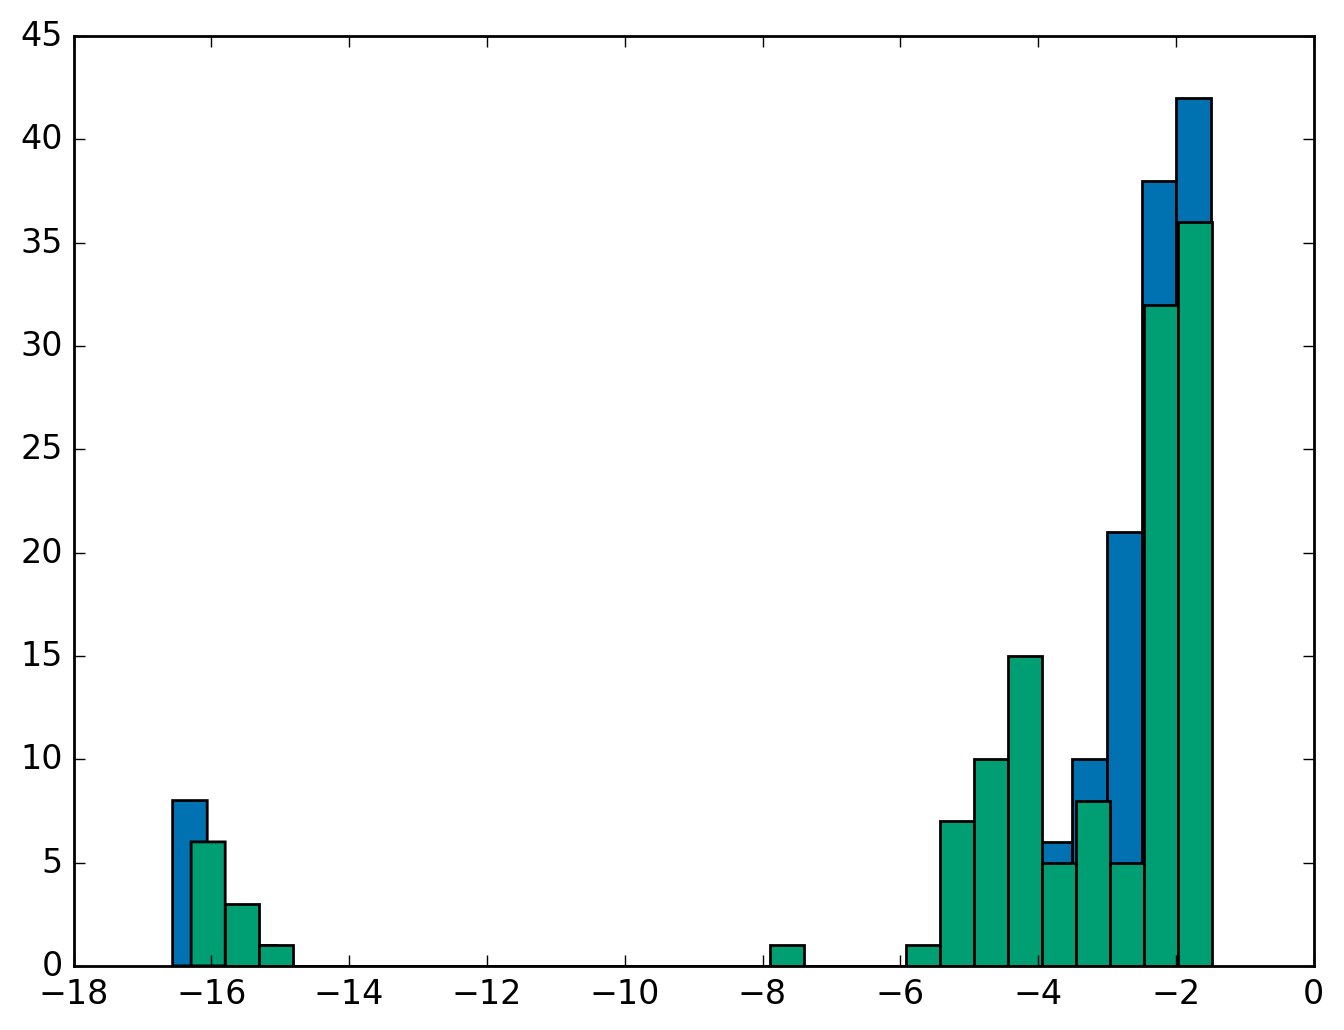

In [247]:
'''------------------------------------------
How do weights compare with different methods?
(they're not quite the same)
------------------------------------------'''

h = plt.hist(np.log10(weights_1),bins=30)
k = plt.hist(np.log10(weights_2),bins=30)

# plt.plot(np.log10(weights_1),np.log10(weights_2),'.')

In [215]:
# l = plt.hist(np.log10(weights_2/weights_1),bins=30)

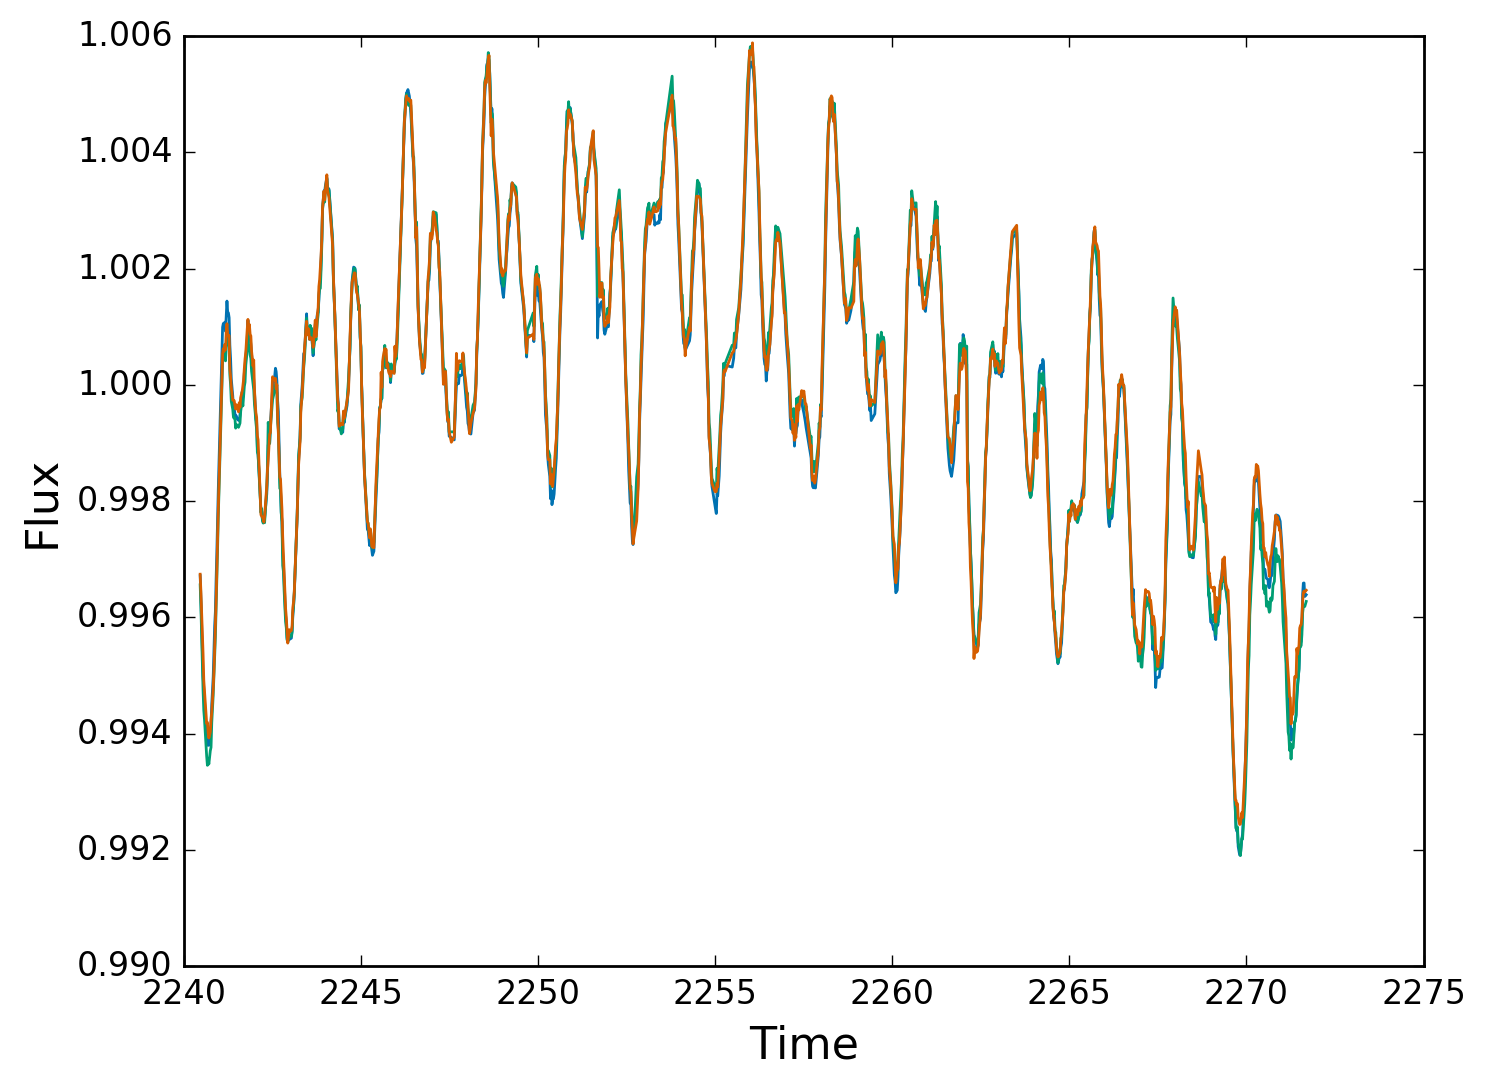

In [228]:
'''------------------------------------------
Plot light curves
------------------------------------------'''

lc_opt_1 = np.dot(weights_1.T,pixels_sub)
lc_opt_2 = np.dot(weights_2.T,pixels_sub)
# lc_opt_2m = np.dot(weights_2m.T,pixels_subm)

time = ts['time']

raw_lc = np.sum(pixels_sub,axis=0)
raw_lcm = np.sum(pixels_subm,axis=0)


# plt.plot(time,raw_lc/np.nanmedian(raw_lc),'.')
# plt.plot(time,raw_lcm/np.nanmedian(raw_lcm),'.')


plt.plot(time,lc_opt_1/np.nanmedian(lc_opt_1),'-')

plt.plot(time,lc_opt_2/np.nanmedian(lc_opt_2),'-')
plt.plot(time,lc_opt_2m/np.nanmedian(lc_opt_2m),'-')
# plt.ylim(0.95,1.05)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.savefig('maskvsnomask_atlas.png')

In [227]:
'''------------------------------------------
Check if the different methods correlate well 
(they do!)
------------------------------------------'''

# plt.plot(lc_opt_2/np.nanmedian(lc_opt_2),lc_opt_2m/np.nanmedian(lc_opt_2m),'.')
# plt.plot(lc_opt_2/np.nanmedian(lc_opt_2),lc_opt_2/np.nanmedian(lc_opt_2),'-')
# plt.xlabel('No mask')
# plt.ylabel('Mask')
# plt.savefig('maskvnomask_1to1.png')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


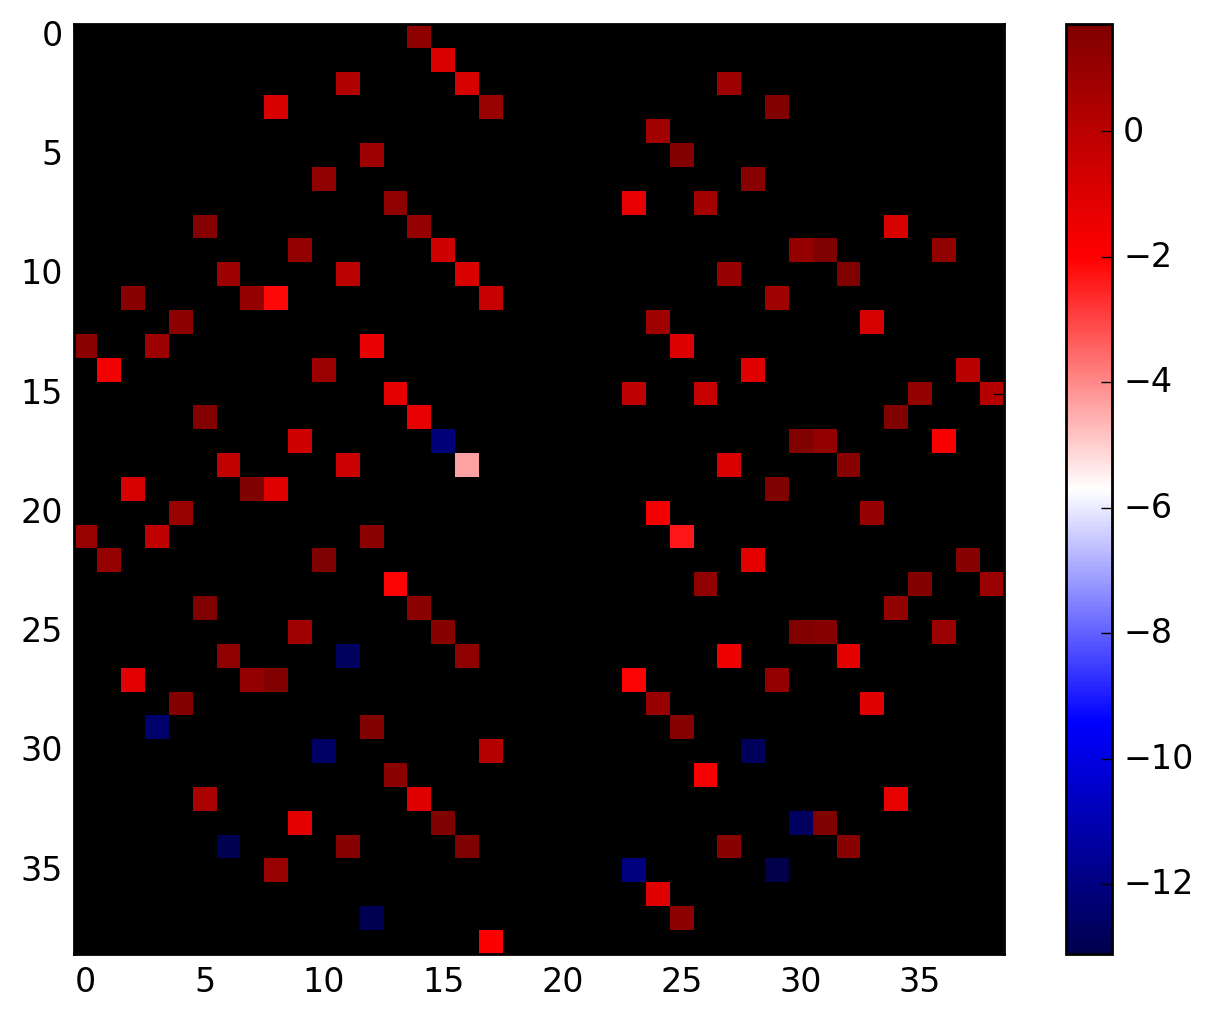

In [241]:
'''------------------------------------------
Make a map of the final weights. Areas set to 
black are masked out, red is high weight, 
bluer is low weight.
------------------------------------------'''

weightmap = pixelmap.copy()
weightmap.ravel()[mapping[0][::sub]] = weights_2

norm = np.size(weightmap)
weightmap = np.ma.array(weightmap,mask=np.isnan(weightmap))
cmap = mpl.cm.seismic
cmap.set_bad('k')
plt.imshow(np.log10(weightmap.T*norm),cmap=cmap,
    interpolation='None')
plt.colorbar()
plt.show()